# Preparing Dataset

## Download Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/"

In [ ]:
!kaggle datasets download bryanb/abstract-art-gallery

 98% 681M/693M [00:18<00:00, 44.8MB/s]
100% 693M/693M [00:18<00:00, 38.4MB/s]


## Unzip Dataset

In [ ]:
!unzip abstract-art-gallery.zip

Archive:  abstract-art-gallery.zip
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_0.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_10.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_100.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1000.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1001.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1002.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1003.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1004.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1005.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1006.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1007.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1008.jpg  
  inflating: Abstract_gal

**rename folder**

In [ ]:
%mv Abstract_gallery/Abstract_gallery Abstract_gallery/1

**import**

In [ ]:
from tensorflow import keras
from keras.layers import Resizing,Conv2D,Conv2DTranspose,Dropout,Dense,Flatten,Activation
from keras.layers import GaussianNoise,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.utils.vis_utils import plot_model
import numpy as np
import matplotlib.pyplot as plt

# Train Dataset Dataloader

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
                                                    directory='Abstract_gallery/',
                                                    labels='inferred',
                                                    label_mode='categorical',
                                                    image_size=(64, 64),
                                                    batch_size=64)

Found 2782 files belonging to 1 classes.


**Scaling the Dataset**

Map to -1 to 1 (tanh activation)

In [ ]:
train_ds = train_ds.map(lambda x, _: x/127.5 - 1)

# Create Generator Model

In [ ]:
noise_shape = 100

In [ ]:
generator = Sequential()

generator.add(Dense(4*4*1024, input_shape=[noise_shape]))
generator.add(Activation('relu'))
generator.add(BatchNormalization())
generator.add(Reshape([4,4,1024]))

generator.add(Conv2DTranspose(512, kernel_size=5, strides=2, padding="same"))
generator.add(Activation('relu'))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding="same"))
generator.add(Activation('relu'))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding="same"))
generator.add(Activation('relu'))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding="same",
                                 activation='tanh'))


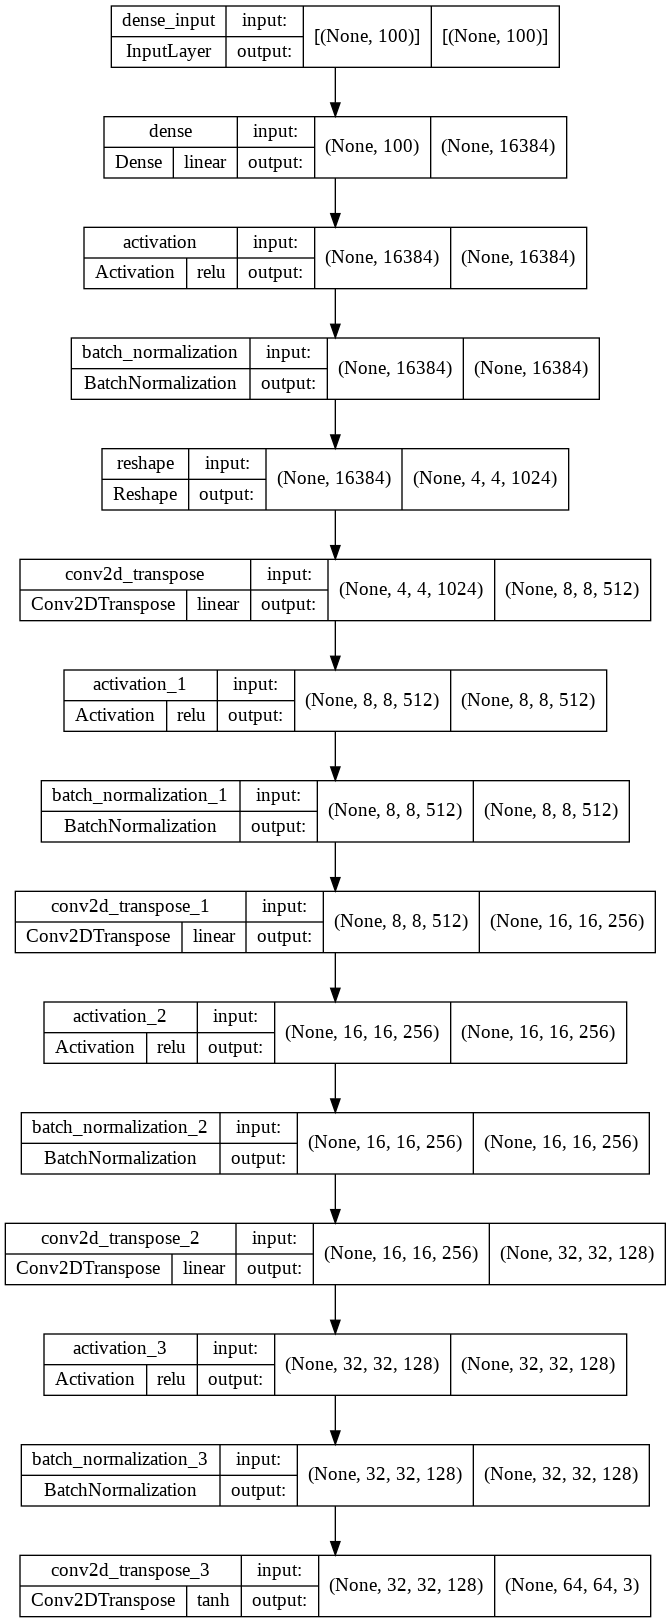

In [ ]:
plot_model(generator, show_shapes=True, show_layer_activations=True)

# Create Discriminator Model (For training D)

In [ ]:
discriminator = Sequential()

discriminator.add(GaussianNoise(0.02, input_shape=[64,64,3]))

discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))

discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))

discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.25))

discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

In [ ]:
discriminator.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy')
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 64, 64, 3)        0         
 se)                                                             
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         819456    
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


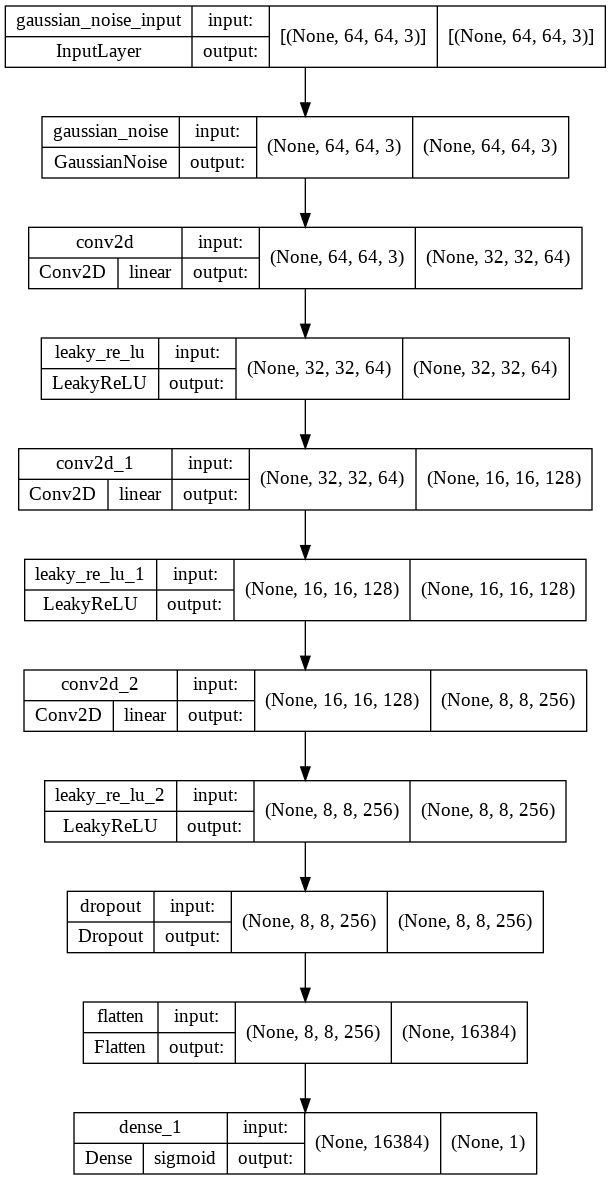

In [ ]:
plot_model(discriminator, show_shapes=True, show_layer_activations=True)

# Create GAN Model (For training G)

In [ ]:
discriminator.trainable = False
GAN = Sequential([generator,discriminator])
GAN.layers[1].trainable = False  # D is not trainable when training G
GAN.compile(optimizer=Adam(lr=0.0002, beta_1=0.5),loss='binary_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


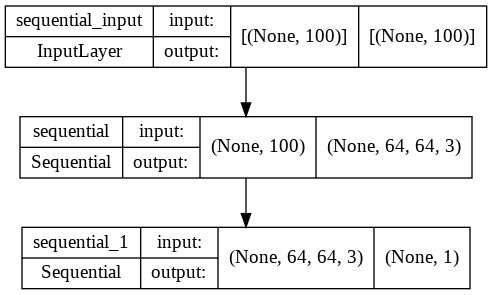

In [ ]:
plot_model(GAN, show_shapes=True, show_layer_activations=True)

In [ ]:
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         18937603  
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1045633   
                                                                 
Total params: 19,983,236
Trainable params: 18,903,043
Non-trainable params: 1,080,193
_________________________________________________________________


In [ ]:
Dloss, Gloss = [], []

In [ ]:
import tensorflow as tf

epoch  20

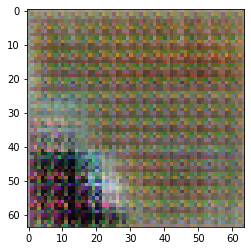

epoch  40

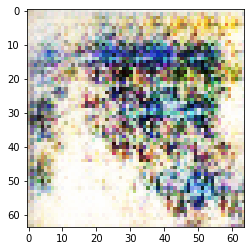

epoch  60

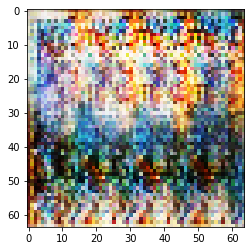

epoch  80

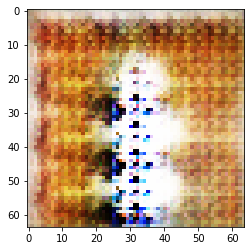

epoch  100

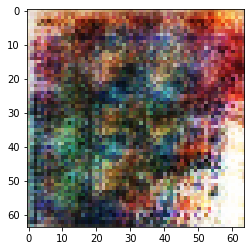

epoch  120

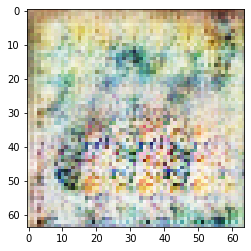

epoch  140

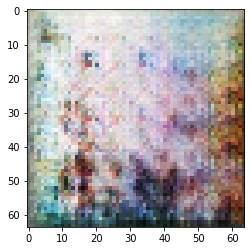

epoch  160

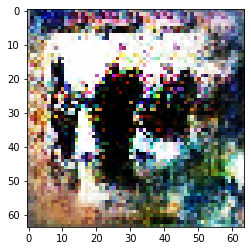

epoch  180

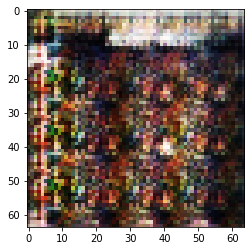

epoch  200

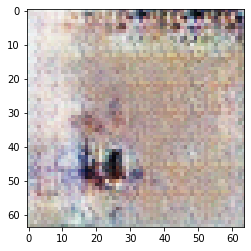

In [ ]:
epochs = 200
batch_size = 64
#y_fake = np.zeros(batch_size)
for epoch in range(epochs):
  for batch in train_ds:
    if batch.shape[0] == batch_size:
      ###### train D
      z = tf.random.normal(shape=[batch_size, 100])
      generated_images = generator(z)
      #discriminator.trainable = True
      #dloss = discriminator.train_on_batch(generated_images, y_fake)
      #y_real = np.ones(batch.shape[0])
      x = tf.concat([generated_images, batch], axis = 0)
      y = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
      dloss = discriminator.train_on_batch(x, y)
      Dloss.append(dloss)
      ###### train G
      #discriminator.trainable = False
      y_real = tf.constant([[1.]] * batch_size)
      z = tf.random.normal(shape=[batch_size, 100])
      gloss = GAN.train_on_batch(z, y_real)
      Gloss.append(gloss)
  print("\repoch ", epoch+1, end='')
  if (epoch+1) % 20 == 0:
    z = np.random.normal(0, 1, [1, 100])
    Gz = generator.predict(z)
    out = (Gz[0]+1)*127.5
    out = out.astype('int32')
    plt.imshow(out)
    plt.show()

In [ ]:
discriminator.trainable = True
discriminator.compile(optimizer=Adam(lr=0.0001, beta_1=0.4), loss='binary_crossentropy')
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 64, 64, 3)        0         
 se)                                                             
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         819456    
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
discriminator.trainable = False
GAN = Sequential([generator,discriminator])
GAN.layers[1].trainable = False  # D is not trainable when training G
GAN.compile(optimizer=Adam(lr=0.0001, beta_1=0.4),loss='binary_crossentropy')
GAN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 sequential (Sequential)     (None, 64, 64, 3)         18937603  
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1045633   
                                                                 
Total params: 19,983,236
Trainable params: 18,903,043
Non-trainable params: 1,080,193
_________________________________________________________________


epoch  20

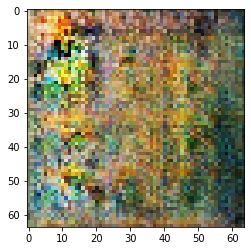

epoch  40

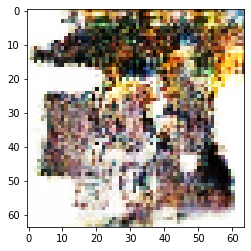

epoch  60

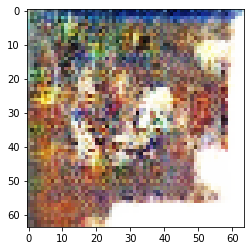

epoch  80

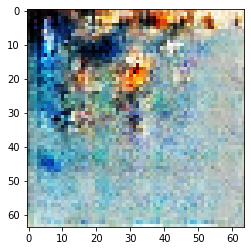

epoch  100

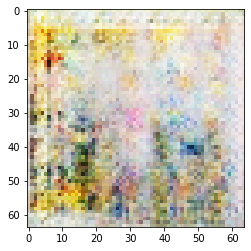

In [ ]:
epochs = 100
batch_size = 64
#y_fake = np.zeros(batch_size)
for epoch in range(epochs):
  for batch in train_ds:
    if batch.shape[0] == batch_size:
      ###### train D
      z = tf.random.normal(shape=[batch_size, 100])
      generated_images = generator(z)
      #discriminator.trainable = True
      #dloss = discriminator.train_on_batch(generated_images, y_fake)
      #y_real = np.ones(batch.shape[0])
      x = tf.concat([generated_images, batch], axis = 0)
      y = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
      dloss = discriminator.train_on_batch(x, y)
      Dloss.append(dloss)
      ###### train G
      #discriminator.trainable = False
      y_real = tf.constant([[1.]] * batch_size)
      z = tf.random.normal(shape=[batch_size, 100])
      gloss = GAN.train_on_batch(z, y_real)
      Gloss.append(gloss)
  print("\repoch ", epoch+1, end='')
  if (epoch+1) % 20 == 0:
    z = np.random.normal(0, 1, [1, 100])
    Gz = generator.predict(z)
    out = (Gz[0]+1)*127.5
    out = out.astype('int32')
    plt.imshow(out)
    plt.show()

In [ ]:
generator.save('drive/MyDrive/generator_random.hdf5')
discriminator.save('drive/MyDrive/discriminator_random.hdf5')

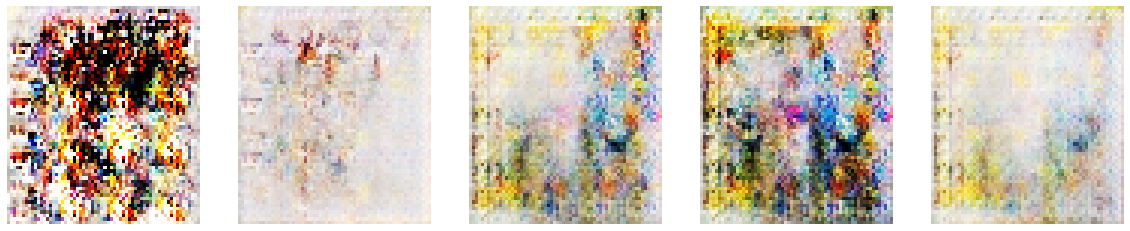

In [ ]:
z = tf.random.normal(shape=[5, 100])
Gz = generator.predict(z)
out = (Gz+1)*127.5
out = out.astype('int32')
fig = plt.figure(figsize=(20,4))
for i in range(5):
  fig.add_subplot(1,5,i+1)
  plt.axis('off')
  plt.imshow(out[i], aspect='auto')
plt.show()